<a href="https://colab.research.google.com/github/QasimKhan5x/Evaluation-Exercise/blob/main/Solution2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will consider all particles that are obj1 where the event ends with j.

In [1]:
#!pip install fastai --upgrade

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

In [44]:
particles = pd.read_csv('monojet_Zp2000.0_DM_50.0_chan3.csv')

In [45]:
# meta columns that we don't need
meta = ['process ID', 'event weight', 'MET', 'METphi']
particles = particles.drop(meta, axis=1)
particles.shape

(6399, 46)

In [46]:
# retain only obj1
particles = particles.loc[:, :'phi1']
particles.shape

(6399, 6)

In [47]:
keep = particles['event ID'].str.split(';').apply(lambda x : x[-1] == 'j')
print(particles.shape)
jets = particles[keep].copy()
print(jets.shape)

(6399, 6)
(6202, 6)


In [48]:
jets.drop('event ID', axis=1, inplace=True)
jets.head()

,obj1,E1,pt1,eta1,phi1
1,457647.0,110079.0,2.102870,2.17501;j,49649.1
2,1240000.0,602104.0,1.343240,-0.550856;j,193865.0
3,75998.0,52304.3,0.905489,-0.806736;,NaN
4,332790.0,126272.0,1.619980,-1.85524;,NaN
5,123709.0,88206.3,0.867744,1.4266;j,47443.5


In [49]:
jets.isna().sum()

obj1     269
E1       269
pt1      269
eta1     269
phi1    1423
dtype: int64

In [51]:
jets.columns

Index(['obj1', 'E1', 'pt1', 'eta1', 'phi1'], dtype='object')

In [52]:
jets.dropna(subset=['obj1'], inplace=True)
jets.isna().sum()

obj1       0
E1         0
pt1        0
eta1       0
phi1    1154
dtype: int64

In [53]:
jets.fillna(1e-5, inplace=True)

In [54]:
jets.drop('obj1', axis=1, inplace=True)
jets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5933 entries, 1 to 6398
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   E1      5933 non-null   float64
 1   pt1     5933 non-null   float64
 2   eta1    5933 non-null   object 
 3   phi1    5933 non-null   float64
dtypes: float64(3), object(1)
memory usage: 231.8+ KB


In [55]:
jets['eta1'] = jets['eta1'].astype(str).str.split(';').apply(lambda x:
                                                             x if type(x) == type(1.0)
                                                             else x[0])
jets['eta1'] = pd.to_numeric(jets['eta1'])
jets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5933 entries, 1 to 6398
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   E1      5933 non-null   float64
 1   pt1     5933 non-null   float64
 2   eta1    5933 non-null   float64
 3   phi1    5933 non-null   float64
dtypes: float64(4)
memory usage: 231.8 KB


In [56]:
jets.head()

,E1,pt1,eta1,phi1
1,110079.0,2.102870,2.175010,49649.10000
2,602104.0,1.343240,-0.550856,193865.00000
3,52304.3,0.905489,-0.806736,0.00001
4,126272.0,1.619980,-1.855240,0.00001
5,88206.3,0.867744,1.426600,47443.50000


In [57]:
jets.columns = ['E', 'pt', 'eta', 'phi']
jets.head()

,E,pt,eta,phi
1,110079.0,2.102870,2.175010,49649.10000
2,602104.0,1.343240,-0.550856,193865.00000
3,52304.3,0.905489,-0.806736,0.00001
4,126272.0,1.619980,-1.855240,0.00001
5,88206.3,0.867744,1.426600,47443.50000


In [58]:
def plot_hist(df):

    unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
    variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

    plt.figure(figsize=(10, 8))
    branches=["pt","eta","phi","E"]
    n_bins = 100
    for kk in range(4):
        plt.subplot(220 + kk + 1)
        n_hist_data, bin_edges, _ = plt.hist(df[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
        plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
        plt.ylabel('# of events')

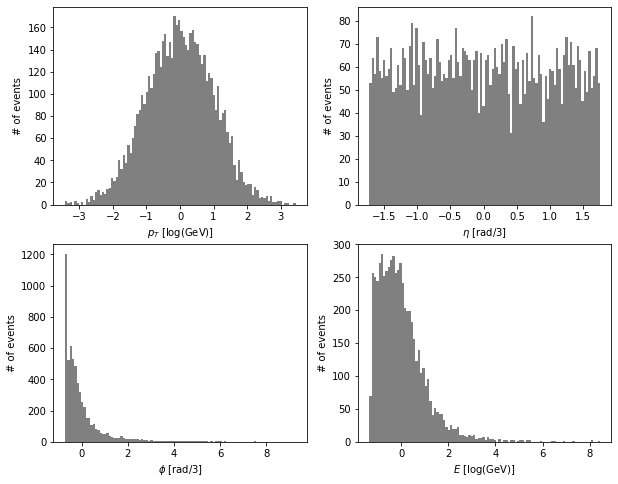

In [59]:
jets_standard = (jets - jets.mean()) / jets.std()
plot_hist(jets_standard)

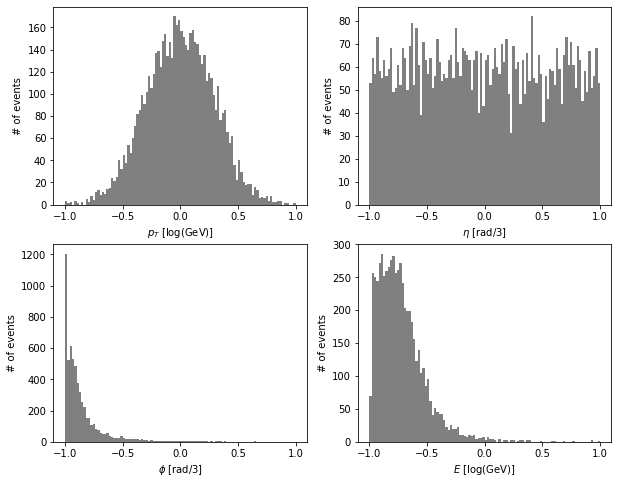

In [60]:
jets11 = 2 * ((jets - jets.min()) / (jets.max() - jets.min())) - 1
plot_hist(jets11)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


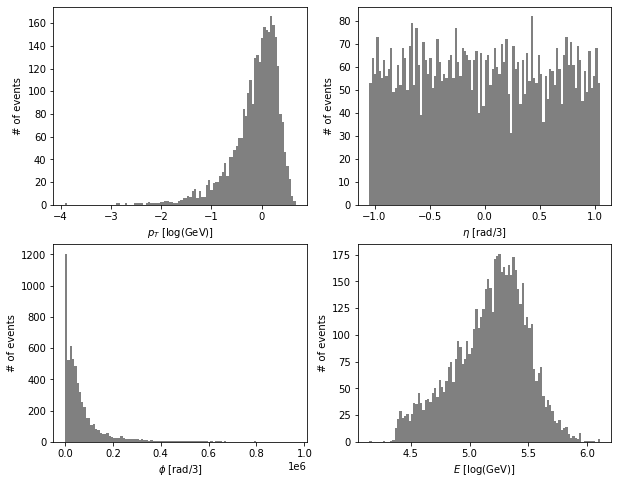

In [61]:
jets_custom = jets.copy()
jets_custom['pt'] = np.log10(jets_custom['pt'])
jets_custom['E'] = np.log10(jets_custom['E'])
jets_custom['eta'] = jets_custom['eta'] / 3
jets_custom['phi'] = jets_custom['phi'] / 3
plot_hist(jets_custom)

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(jets, test_size=0.2)

In [ ]:
X_train['E'] = np.log10(X_train['E'])
X_train['eta'] = (X_train['eta'] - X_train['eta'].mean()) / X_train['eta'].std()
X_train['phi'] = (X_train['phi'] - X_train['phi'].mean()) / X_train['phi'].std() 
X_train['pt'] = (X_train['pt'] - X_train['pt'].mean()) / X_train['pt'].std()

X_valid['E'] = np.log10(X_valid['E'])
X_valid['eta'] = (X_valid['eta'] - X_valid['eta'].mean()) / X_valid['eta'].std()
X_valid['phi'] = (X_valid['phi'] - X_valid['phi'].mean()) / X_valid['phi'].std() 
X_valid['pt'] = (X_valid['pt'] - X_valid['pt'].mean()) / X_valid['pt'].std() 

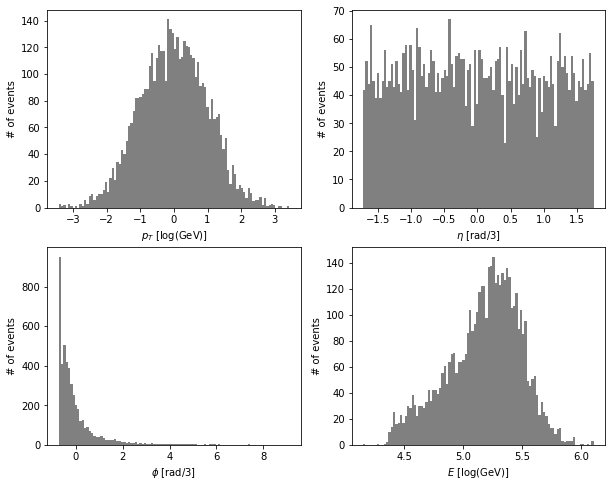

In [77]:
plot_hist(X_train)

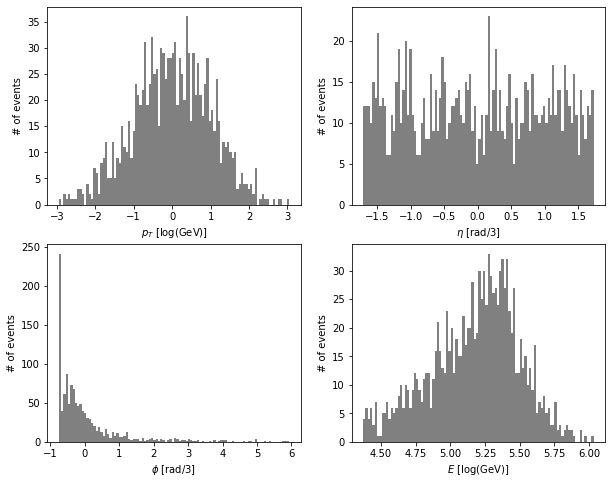

In [78]:
plot_hist(X_valid)

In [79]:
# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(X_train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(X_valid.values, dtype=torch.float), torch.tensor(X_valid.values, dtype=torch.float))

In [80]:
len(train_ds), len(valid_ds)

(4746, 1187)

In [81]:
bs = 32

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

In [82]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [83]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

Learning rate with the minimum loss: 0.012022644281387329
Learning rate with the steepest gradient: 0.001737800776027143


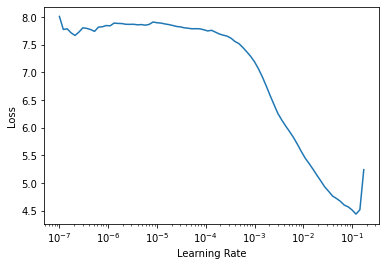

In [84]:
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [85]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_steep)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')


[0, 2.1784582138061523, 0.8562366366386414, '00:01']
[0, 2.1784582138061523, 0.8562366366386414, '00:01']
[1, 0.810171902179718, 0.7751548290252686, '00:01']
[1, 0.810171902179718, 0.7751548290252686, '00:01']
[2, 0.7771968841552734, 0.7517016530036926, '00:01']
[2, 0.7771968841552734, 0.7517016530036926, '00:01']
[3, 0.4791587293148041, 0.31889039278030396, '00:00']
[3, 0.4791587293148041, 0.31889039278030396, '00:00']
[4, 0.2639419138431549, 0.18897892534732819, '00:01']
[4, 0.2639419138431549, 0.18897892534732819, '00:01']
[5, 0.05614759773015976, 0.02564728818833828, '00:01']
[5, 0.05614759773015976, 0.02564728818833828, '00:01']
[6, 0.028547193855047226, 0.0231759175658226, '00:01']
[6, 0.028547193855047226, 0.0231759175658226, '00:01']
[7, 0.023540271446108818, 0.022570526227355003, '00:01']
[7, 0.023540271446108818, 0.022570526227355003, '00:01']
[8, 0.023346105590462685, 0.02123837359249592, '00:01']
[8, 0.023346105590462685, 0.02123837359249592, '00:01']
[9, 0.0226150210946798

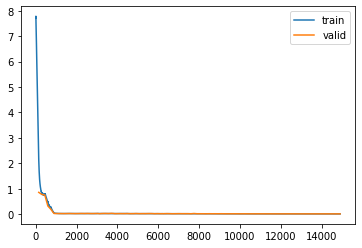

In [86]:
recorder.plot_loss()

In [87]:
learn.validate()

(#1) [0.01029413752257824]

In [88]:
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [89]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * df['eta'].std() + df['eta'].mean()
    df['phi'] = df['phi'] * df['phi'].std() + df['phi'].mean()
    df['pt'] = df['pt'] * df['pt'].std() + df['pt'].mean()
    df['E'] = 10**df['E']
    return df

In [90]:
def plot_comparison(df):
    plt.close('all')
    unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
    variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
    line_style = ['--', '-']
    colors = ['orange', 'c']
    markers = ['*', 's']

    model.to('cpu')

    save = False # Option to save figure

    # Histograms
    idxs = (0, 100000)  # Choose events to compare
    data = torch.tensor(df[idxs[0]:idxs[1]].values, dtype=torch.float)
    pred = model(data)
    pred = pred.detach().numpy()
    data = data.detach().numpy()

    data_df = pd.DataFrame(data, columns=df.columns)
    pred_df = pd.DataFrame(pred, columns=df.columns)

    unnormalized_data_df = custom_unnormalize(data_df)
    unnormalized_pred_df = custom_unnormalize(pred_df)    
        
    alph = 0.8
    n_bins = 200
    plt.figure(figsize=(10, 8))
    for kk in np.arange(4):
        plt.subplot(220 + kk + 1)
        n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
        n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
        plt.suptitle(df.columns[kk])
        plt.xlabel(df.columns[kk])
        plt.ylabel('Number of events')
        # ms.sciy()
        plt.yscale('log')
        if save:
            plt.savefig(os.path.join(save_dir,df.columns[kk]+'.png'))
        plt.legend()

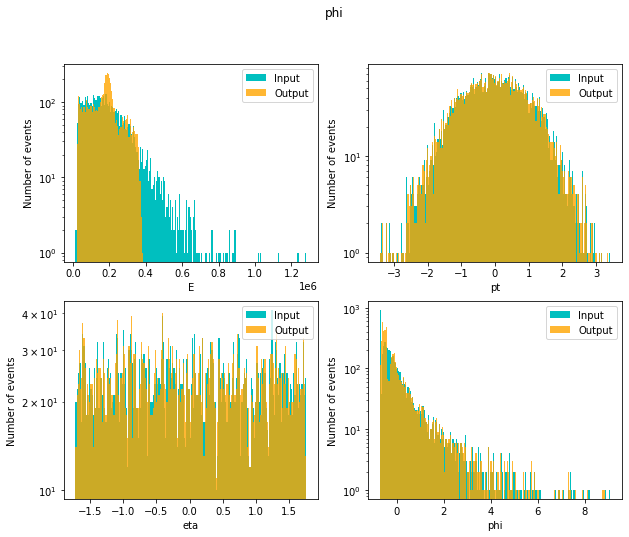

In [91]:
plot_comparison(X_train)

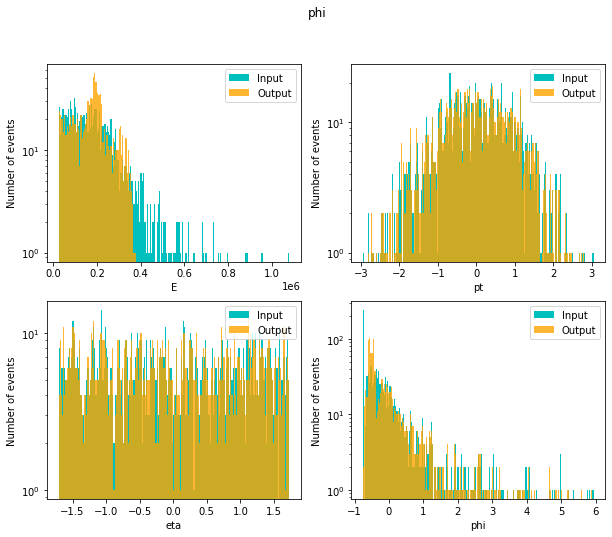

In [92]:
plot_comparison(X_valid)